**@author: James V. Talwar**

# Leave-One-Out Analysis: MHC-I Autoimmune Allele Holdout and Age of Diagnosis in the TCGA

**About**: This notebook provides the code needed to generate **Supplementary Figure 6** and associated analyses from the paper [*Autoimmune Alleles at the Major Histocompatibility Locus Modify Melanoma Susceptibility*](https://www.biorxiv.org/content/10.1101/2021.08.12.456166v1.full). These analyses investigated the effect of omitting each of the 7 individual autoimmune (AI) alleles from carrier status in TCGA.

## 1. Import Packages; Load Data

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import mannwhitneyu
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from statsmodels.stats.multitest import multipletests

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
#get AI alleles
autoimmuneAlleles = set(pd.read_csv("../Data/AutoimmuneAlleles.tsv", sep = "\t", header = None)[0].tolist())
autoimmuneAlleles

{'HLA-B13:02',
 'HLA-B27:05',
 'HLA-B39:06',
 'HLA-B51:01',
 'HLA-B57:01',
 'HLA-C06:02',
 'HLA-C12:03'}

Load in TCGA summary dataframe (MHC-I genotypes, Age of Diagnosis, Sex, etc.):

In [3]:
tcgaSummary = pd.read_csv("../GenotypeData/TCGA_Summary_With_BRAFV600E_Mutation_Status.tsv", index_col = 0, sep = "\t")

#Ensure AI Allele Status is correct
tcgaSummary["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in tcgaSummary.iterrows()]

#Filter out individuals < 20 years old given increased likelihood of rare germline predisposing variants.
tcgaSummary = tcgaSummary[tcgaSummary.Age >= 20]

## 2. Run Analyses and Generate Figure:

Run statistical analysis (MWU) with each of the 7 AI alleles heldout:

In [4]:
pValues = defaultdict(float)
for autoimmune in sorted(autoimmuneAlleles):
    temp = tcgaSummary.copy()
    
    #Define a new "smaller AI set" that contains the 6 non-heldout alleles:
    smallerAutoimmuneSet = autoimmuneAlleles.difference({autoimmune}) 
    
    key = "Autoimmune allele status with {} missing:".format(autoimmune)  
    temp[key] = [len(set(row["A1":"C2"]).intersection(smallerAutoimmuneSet)) > 0 for i,row in temp.iterrows()]
    
    _, p = mannwhitneyu(temp[temp[key]]["Age"], temp[~temp[key]]["Age"])
    
    pValues[key] = p

print("Uncorrected p-values for each holdout are:\n")
for k,v in pValues.items():
    print("{} p = {}".format(k, v))

Uncorrected p-values for each holdout are:

Autoimmune allele status with HLA-B13:02 missing: p = 0.001383418978749571
Autoimmune allele status with HLA-B27:05 missing: p = 0.004195242231155217
Autoimmune allele status with HLA-B39:06 missing: p = 0.003903996156257701
Autoimmune allele status with HLA-B51:01 missing: p = 0.009053937237805424
Autoimmune allele status with HLA-B57:01 missing: p = 0.0019039679547465682
Autoimmune allele status with HLA-C06:02 missing: p = 0.006271626587979251
Autoimmune allele status with HLA-C12:03 missing: p = 0.00041877063542670664


Correct p-values (multiple hypothesis correction):

In [5]:
correction = multipletests(pvals = [el[1] for el in sorted(pValues.items(), key = lambda x: x[1])], alpha = 0.05, method = "fdr_bh")
print("{}/{} AI allele holdouts are significant after correction.\n".format(sum(correction[0]), len(autoimmuneAlleles)))

correctedPValues = defaultdict(float)
index = 0
for el in sorted(pValues.items(), key = lambda x: x[1]):
    correctedPValues[el[0]] = correction[1][index]
    index += 1

print("Corrected p-values for each holdout are:\n")
for k,v in correctedPValues.items():
    print("{} p = {}".format(k, v))

7/7 AI allele holdouts are significant after correction.

Corrected p-values for each holdout are:

Autoimmune allele status with HLA-C12:03 missing: p = 0.0029313944479869465
Autoimmune allele status with HLA-B13:02 missing: p = 0.004442591894408659
Autoimmune allele status with HLA-B57:01 missing: p = 0.004442591894408659
Autoimmune allele status with HLA-B39:06 missing: p = 0.005873339123617304
Autoimmune allele status with HLA-B27:05 missing: p = 0.005873339123617304
Autoimmune allele status with HLA-C06:02 missing: p = 0.007316897685975793
Autoimmune allele status with HLA-B51:01 missing: p = 0.009053937237805424


Generate figure:

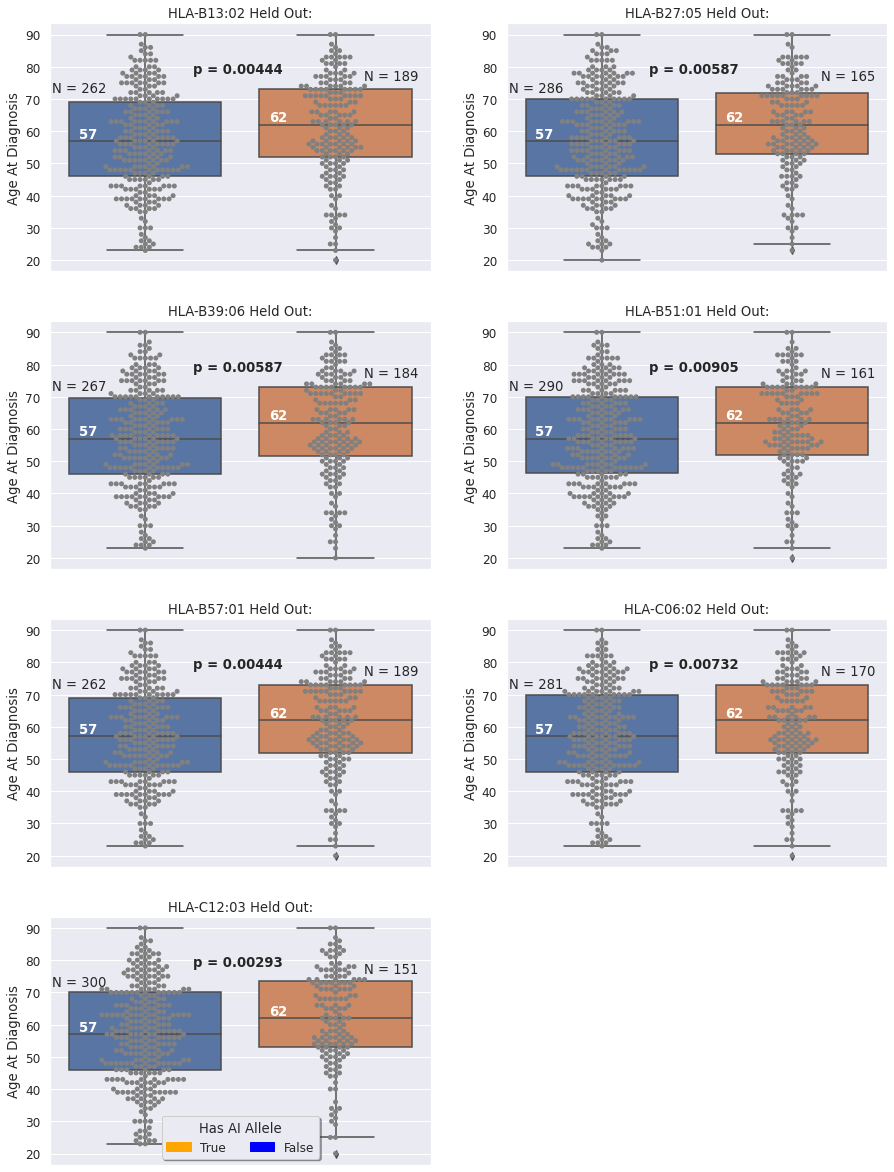

In [13]:
sns.set(font_scale = 1.1)
fig, axs = plt.subplots(4,2, figsize = (15, 21))
xPlot = 0
yPlot = 0

for autoimmune in sorted(autoimmuneAlleles):
    temp = tcgaSummary.copy()
    
    #Define a new "smaller AI set" that contains the 6 non-heldout alleles:
    smallerAutoimmuneSet = autoimmuneAlleles.difference({autoimmune}) 
    
    key = "Autoimmune allele status with {} missing:".format(autoimmune)  
    temp[key] = [len(set(row["A1":"C2"]).intersection(smallerAutoimmuneSet)) > 0 for i,row in temp.iterrows()]
    
    sns.boxplot(data = temp, x = key, y = "Age", ax = axs[xPlot, yPlot])
    sns.swarmplot(data = temp, x = key, y = "Age", ax = axs[xPlot, yPlot], dodge = True, color = "grey")
    
    axs[xPlot, yPlot].set_title("{} Held Out:".format(autoimmune))
    axs[xPlot, yPlot].set_xticks([])
    axs[xPlot, yPlot].set_xlabel("")
    axs[xPlot, yPlot].set_ylabel("Age At Diagnosis")

    bottom, top = axs[xPlot, yPlot].get_ylim()
    
    p = correctedPValues[key]
    if p <= 0.05:
        axs[xPlot, yPlot].text(0.25, 0.8 * top + 0.2 * bottom, "p = {:.5f}".format(p), fontweight = "bold")
    else: 
        axs[xPlot, yPlot].text(0.25, 0.8 * top + 0.2 * bottom, "p = {:.5f}".format(p))

    axs[xPlot, yPlot].text(-0.49, 72, f'N = {temp[~temp[key]].shape[0]}')
    axs[xPlot, yPlot].text(1.15, 76, f'N = {temp[temp[key]].shape[0]}')
    axs[xPlot, yPlot].text(-0.35, 58, int(np.median(temp[~temp[key]].Age)), color = "white", weight = "bold")
    axs[xPlot, yPlot].text(0.65, 63, int(np.median(temp[temp[key]].Age)), color = "white", weight = "bold")
    
    #increment axes accordingly:
    yPlot = (yPlot + 1) % 2
    if yPlot == 0:
        xPlot += 1 
        
fig.delaxes(axs[3,1]) #Remove the empty subplot

# add legend
plt.legend(title='Has AI Allele', labels=["True", "False"],
           handles=[mpatches.Patch(color='orange'), mpatches.Patch(color='blue')],
           fancybox=True, shadow=True, ncol=5, loc='best')